# Todo: Stemming & stopword removal für Kandidat & Anforderung fertigmachen

### Prüfen und installieren der benötigten Pakete

In [236]:
if (!require("stringdist")) {
   install.packages("stringdist", repos="https://cran.uni-muenster.de/")
   library(stringdist)
   }

if (!require("plotly")) {
   install.packages("plotly", repos="https://cran.uni-muenster.de/")
   library(plotly)
   }

if (!require("RColorBrewer")) {
   install.packages("RColorBrewer", repos="https://cran.uni-muenster.de/")
   library(RColorBrewer)
   }

if (!require("gplots")) {
   install.packages("gplots", dependencies = TRUE,repos="https://cran.uni-muenster.de")
   library(gplots)
   }

if (!require("tm")) {
   install.packages("tm", dependencies = TRUE,repos="https://cran.uni-muenster.de")
   library(tm)
   }

if (!require("SnowballC")) {
   install.packages("SnowballC", dependencies = TRUE,repos="https://cran.uni-muenster.de")
   library(SnowballC)
   }

library(reshape2)
library(dplyr)


Attaching package: 'dplyr'

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



In [283]:
# Optional
# install.packages("data.tree", repos="https://cran.uni-muenster.de/")
# library(data.tree)

### Laden der Daten

In [658]:
AnforderungenDB <- read.csv("skillsDB.csv", sep=";")

In [659]:
KenntnisseDB <- read.csv("skills.csv", sep=";")

### Untersuchen der Daten

In [660]:
dim(AnforderungenDB)

[1] 47  2

In [661]:
dim(KenntnisseDB)

[1] 154   1

AnforderungenDB ist eine Liste von Anforderungen (z.B. für eine zu besetzende Stelle), gegen die wir die Kenntnisse matchen.

In [662]:
head(AnforderungenDB)

Skill,Kategorie
V-Modell,Entwicklungsmethoden
Wasserfallmodell,Entwicklungsmethoden
Spiralmodell,Entwicklungsmethoden
Agile Modelle,Entwicklungsmethoden
Scrum,Entwicklungsmethoden
test-driven development,Entwicklungsmethoden


KenntnisseDB ist eine Liste von Kenntnissen (z.B. aus dem CV eines Bewerbers), die wir gegen unsere Anforderungen matchen. Die Kenntnisse enthalten unterschiedliche Schreibweisen und Rechtschreibfehler.

In [663]:
head(KenntnisseDB)

Skill
V-Modell
Entwicklung nach V-Modell
VModell
V-Model
Wasserfallmodell
waterfall model


Zufälliges Ziehen von 20 Zeilen aus KenntnisseDB, um ein Kandidatenprofil aus 20 Skills zu simulieren

In [664]:
Kandidat <-KenntnisseDB[sample(nrow(KenntnisseDB),20, replace=F),]
Kandidat

[1] VBScript                    HTML Entwicklung           
 [3] Programmieren in C++        ABAP                       
 [5] Softwareentwicklung in C    Agile Softwareentwicklung  
 [7] Javascript                  Simulation                 
 [9] Dokumentation               Visual basic Programmierung
[11] Visual Basic                SUCRM                      
[13] HTML Programmierung         SAP-CO                     
[15] C#-Programmierung           SAP-HR                     
[17] Java                        Projektmanagement          
[19] Agile Entwicklung           SAP BW                     
154 Levels: ABAP ABAP-Development ABAP Entwicklung ... waterfall model

Zufälliges Ziehen von 10 Zeilen aus AnforderungenDB, um ein Stellenprofil aus 10 Skills zu simulieren

In [665]:
Anforderungen <- AnforderungenDB[sample(nrow(AnforderungenDB), 10, replace=F),]
Anforderungen

,Skill,Kategorie
4,Agile Modelle,Entwicklungsmethoden
29,PostgreSQL,Datenbanken
18,Javascript,Programmiersprachen
9,C++,Programmiersprachen
37,Modulbetreuung,Business IT
2,Wasserfallmodell,Entwicklungsmethoden
20,Perl,Programmiersprachen
40,Design,Erfahrungen
47,Qualitätsmanagement,Erfahrungen
12,Delphi,Programmiersprachen


### Preprocessing

Um die Berechnung der Ähnlichkeit zu vereinfachen werden zunächst die Strings zu lowercase transformiert.

In [666]:
Anforderungen$Skill <- sapply(Anforderungen$Skill, tolower)
Anforderungen

,Skill,Kategorie
4,agile modelle,Entwicklungsmethoden
29,postgresql,Datenbanken
18,javascript,Programmiersprachen
9,c++,Programmiersprachen
37,modulbetreuung,Business IT
2,wasserfallmodell,Entwicklungsmethoden
20,perl,Programmiersprachen
40,design,Erfahrungen
47,qualitätsmanagement,Erfahrungen
12,delphi,Programmiersprachen


In [667]:
Kandidat <- tolower(Kandidat)
Kandidat

[1] "vbscript"                    "html entwicklung"           
 [3] "programmieren in c++"        "abap"                       
 [5] "softwareentwicklung in c"    "agile softwareentwicklung"  
 [7] "javascript"                  "simulation"                 
 [9] "dokumentation"               "visual basic programmierung"
[11] "visual basic"                "sucrm"                      
[13] "html programmierung"         "sap-co"                     
[15] "c#-programmierung"           "sap-hr"                     
[17] "java"                        "projektmanagement"          
[19] "agile entwicklung"           "sap bw"

Dann werden "-" durch Leerzeichen ersetzt.

In [668]:
Anforderungen$Skill <- gsub("-", " ", Anforderungen$Skill)

Um die Funktionen der Bibliothek "tm" nutzen zu können, muss der Datensatz transformiert werden:

In [669]:
docs <- VCorpus(VectorSource(Anforderungen$Skill))

Dann wird stemming und stopword removal durchgeführt

In [670]:
docs <- tm_map(docs, removeWords, stopwords("german"))

In [671]:
docs <- tm_map(docs, stemDocument)

In [672]:
data <- data.frame(lapply(docs, as.character))

In [676]:
mdata <- t(data)

In [677]:
data

X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
agil modell,postgresql,javascript,c++,modulbetreuung,wasserfallmodel,perl,design,qualitätsmanag,delphi


In [678]:
mdata

X1,agil modell
X2,postgresql
X3,javascript
X4,c++
X5,modulbetreuung
X6,wasserfallmodel
X7,perl
X8,design
X9,qualitätsmanag
X10,delphi


In [679]:
rownames(mdata)<- rownames(Anforderungen)
colnames(mdata) <- "Skill"

In [680]:
mdata

,Skill
4,agil modell
29,postgresql
18,javascript
9,c++
37,modulbetreuung
2,wasserfallmodel
20,perl
40,design
47,qualitätsmanag
12,delphi


In [681]:
Anforderungen$Skill <- mdata

In [682]:
Anforderungen

,Skill,Kategorie
4,agil modell,Entwicklungsmethoden
29,postgresql,Datenbanken
18,javascript,Programmiersprachen
9,c++,Programmiersprachen
37,modulbetreuung,Business IT
2,wasserfallmodel,Entwicklungsmethoden
20,perl,Programmiersprachen
40,design,Erfahrungen
47,qualitätsmanag,Erfahrungen
12,delphi,Programmiersprachen


In [683]:
Kandidat <- gsub("-", " ", Kandidat)
Kandidat

[1] "vbscript"                    "html entwicklung"           
 [3] "programmieren in c++"        "abap"                       
 [5] "softwareentwicklung in c"    "agile softwareentwicklung"  
 [7] "javascript"                  "simulation"                 
 [9] "dokumentation"               "visual basic programmierung"
[11] "visual basic"                "sucrm"                      
[13] "html programmierung"         "sap co"                     
[15] "c# programmierung"           "sap hr"                     
[17] "java"                        "projektmanagement"          
[19] "agile entwicklung"           "sap bw"

### Berechnung der String Distances

Um festzustellen, wie ähnlich sich Kenntnisse und Anforderungen sind, werden sie kreuzweise verglichen.

In [691]:
similarity_matrix <- data.frame(stringdistmatrix(Anforderungen$Skill,
                                                 Kandidat,
                                                 method = c("jw"),
                                                 p=0.25,
                                                 q=2,
                                                 useNames="strings",
                                                useBytes = TRUE))

In [694]:
similarity_matrix # eigentlich distance matrix, 0=identisch

,vbscript,html.entwicklung,programmieren.in.c..,abap,softwareentwicklung.in.c,agile.softwareentwicklung,javascript,simulation,dokumentation,visual.basic.programmierung,visual.basic,sucrm,html.programmierung,sap.co,c..programmierung,sap.hr,java,projektmanagement,agile.entwicklung,sap.bw
agil modell,0.594696970,0.443181818,0.480735931,0.414772727,0.579040404,0.000000000,0.603030303,0.495454545,0.609945610,0.520089787,0.517676768,0.569696970,0.462918660,0.409090909,0.550445633,0.494949495,0.553030303,0.683600713,0.000000000,0.494949495
postgresql,0.552777778,0.615277778,0.387500000,0.550000000,0.438888889,0.506666667,0.533333333,0.533333333,0.600854701,0.571604938,0.594444444,0.466666667,0.477192982,0.566666667,0.501960784,0.511111111,1.000000000,0.365931373,0.579901961,0.655555556
javascript,0.141666667,0.615277778,0.591666667,0.433333333,0.494444444,0.497777778,0.000000000,0.566666667,0.656410256,0.467901235,0.461111111,0.366666667,0.578947368,0.511111111,0.535294118,0.511111111,0.000000000,0.568627451,0.579901961,0.655555556
c++,0.513888889,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000,0.543209877,1.000000000,1.000000000,1.000000000,1.000000000,0.401960784,1.000000000,1.000000000,1.000000000,1.000000000,1.000000000
modulbetreuung,0.581349206,0.497023810,0.507142857,0.559523810,0.457010582,0.424973545,0.719047619,0.380952381,0.439560440,0.485890653,0.511904762,0.561904762,0.442634364,0.587301587,0.572829132,0.587301587,1.000000000,0.423494398,0.457983193,0.587301587
wasserfallmodel,0.538888889,0.648611111,0.544444444,0.455555556,0.508333333,0.396767677,0.569444444,0.569444444,0.600213675,0.503703704,0.550000000,0.400000000,0.566959064,0.544444444,0.590849673,0.544444444,0.455555556,0.499019608,0.590849673,0.544444444
perl,0.541666667,0.625000000,0.358333333,1.000000000,0.638888889,0.543333333,0.550000000,0.550000000,0.557692308,0.641975309,0.555555556,0.516666667,0.530701754,0.527777778,0.460784314,0.527777778,1.000000000,0.351715686,0.627450980,0.527777778
design,0.472222222,0.548611111,0.461111111,1.000000000,0.555555556,0.455555556,0.488888889,0.400000000,0.317307692,0.574074074,0.666666667,0.544444444,0.593567251,0.555555556,0.591503268,0.555555556,1.000000000,0.552287582,0.449346405,0.555555556
qualitätsmanag,0.538888889,0.519444444,0.594444444,0.561111111,0.556746032,0.457777778,0.569444444,0.416666667,0.450671551,0.503703704,0.533333333,0.488888889,0.594736842,0.588888889,0.524183007,0.588888889,0.561111111,0.554575163,0.526797386,0.588888889
delphi,0.638888889,0.444444444,0.616666667,0.527777778,0.527777778,0.571111111,0.577777778,0.655555556,0.317307692,0.629629630,0.666666667,1.000000000,0.499269006,0.555555556,0.516339869,0.444444444,1.000000000,0.683006536,0.552287582,0.555555556


### Finde die Paare mit der größten Ähnlichkeit pro Zeile

In [695]:
result <- t(sapply(seq(nrow(similarity_matrix)), function(i) {
  most_similar <- which.min(similarity_matrix[i,])
  c(paste(rownames(similarity_matrix)[i], colnames(similarity_matrix)[most_similar], sep=' | '),
    similarity_matrix[i,most_similar])
}))

result

agil modell | agile.softwareentwicklung,0
postgresql | projektmanagement,0.36593137254902
javascript | javascript,0
c++ | c..programmierung,0.401960784313726
modulbetreuung | simulation,0.380952380952381
wasserfallmodel | agile.softwareentwicklung,0.396767676767677
perl | projektmanagement,0.35171568627451
design | dokumentation,0.317307692307692
qualitätsmanag | simulation,0.416666666666667
delphi | dokumentation,0.317307692307692


In [696]:
typeof(result["Distanz"])

[1] "character"

In [697]:
colnames(result) <- c("Skillpaar","Distanz")

In [698]:
result <- as.data.frame(result)
result$Distanz <- as.numeric(as.character(result$Distanz))
rownames(result) <- rownames(Anforderungen)

In [699]:
result

,Skillpaar,Distanz
4,agil modell | agile.softwareentwicklung,0.000000000
29,postgresql | projektmanagement,0.365931373
18,javascript | javascript,0.000000000
9,c++ | c..programmierung,0.401960784
37,modulbetreuung | simulation,0.380952381
2,wasserfallmodel | agile.softwareentwicklung,0.396767677
20,perl | projektmanagement,0.351715686
40,design | dokumentation,0.317307692
47,qualitätsmanag | simulation,0.416666667
12,delphi | dokumentation,0.317307692


### Zeige nur die Skills, die gematcht werden konnten

Der Threshold wurde auf 0.25 maximale Jaro-Winkler Distanz gesetzt

In [700]:
filter(result, Distanz<=0.25)
cat("Anzahl der gematchten Skills:", nrow(filter(result, Distanz<=0.25)))

Skillpaar,Distanz
agil modell | agile.softwareentwicklung,0
javascript | javascript,0


Anzahl der gematchten Skills: 2

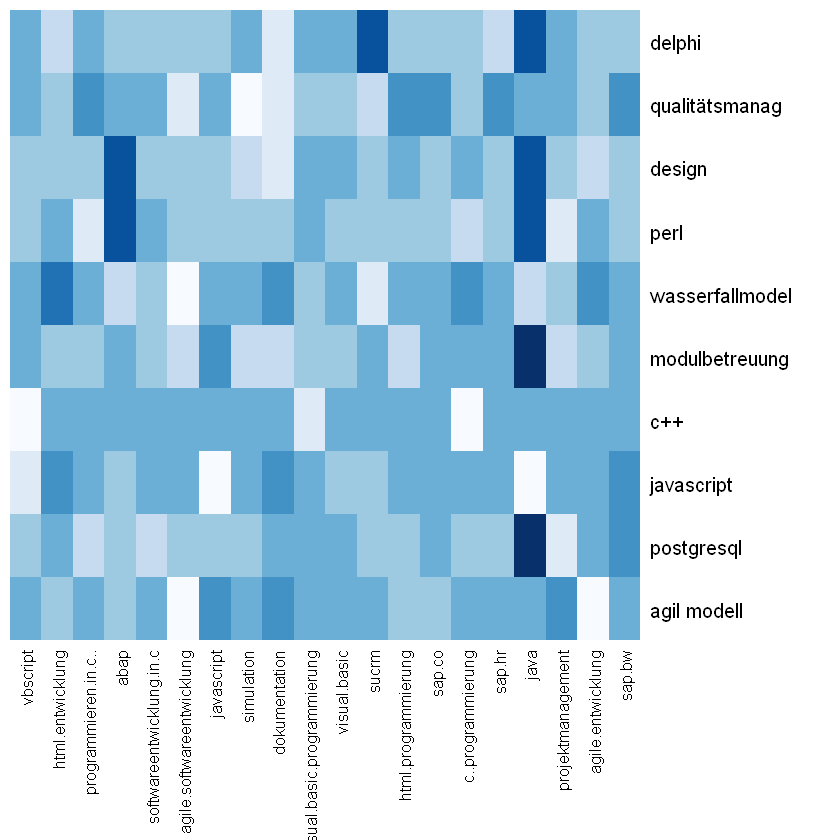

In [701]:
heatmap(as.matrix(similarity_matrix), Rowv=NA, Colv=NA, col=brewer.pal(9,"Blues"), margins =c(10,10))
